In [1]:
## Loding libraries
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import arviz as az
import pickle

In [2]:
## Preprocecing ##
jh_dir = "../../COVID-19"
Confirmed = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df
confirmed = confirmed.cummax()
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.cummax()
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.cummax()

In [3]:
## Definitions ##

In [4]:
### dates ###
epoch = pd.to_datetime('2020-01-22')
last = pd.to_datetime('2020-05-06')
upto = last-pd.Timedelta(days=2)
index= pd.date_range(start=epoch, end=upto)

In [5]:
### Fitting a model ###
def fit_and_infer(sm=None, data=None, country=None, population=None, detection_rate=1,
                  b_beta_0=0.1, inits='random', iteration=2000, start=epoch, last=last):
    if data is None:
        C0 = confirmed.loc[epoch:last, country].values
        D0 = death.loc[epoch:last, country].values
        P = population
        data = {'T': C0.shape[0], 'T0': 0, 'P': P, 'C0': C0, 'D0':D0, 
                'q0':detection_rate, 'b_beta_0':b_beta_0}
    fit = sm.sampling(data=data, iter=iteration, init=inits)
    print(fit)
    return az.from_pystan(fit, log_likelihood='log_lik')

In [6]:
### Extract data ###
def extract_var(var_name=None, data=None, start=epoch):
    d = data.posterior[var_name].stack(sample=('chain', 'draw')).values
    return pd.DataFrame(d, index=pd.date_range(start, end=start+pd.Timedelta(days=len(d)-1)))

In [7]:
### Drawing ###
def draw(data, index=index, name=None, line=None, label_name=None, value_name='value'):
    df = pd.DataFrame()
    dfs = []
    for label, samples in data.items():
        samples['Date'] = samples.index
        melted=pd.melt(samples, id_vars=['Date'])
        if label_name is not None:
            melted[label_name]=label
        dfs.append(melted)
    df = pd.concat(dfs)
    df = df.rename(columns={'value':value_name})
    if label_name is not None:
        g=sns.relplot(kind="line", data=df, aspect=2, ci='sd', x='Date', y=value_name, hue=label_name)
    else:
        g=sns.relplot(kind="line", data=df, aspect=2, ci='sd', x='Date', y=value_name)
    ax = g.axes[0][0]
    if line is not None:
        ax.axhline(y = line, color='grey', linestyle='--', linewidth=2, alpha=.7)
    g.savefig("{}.pdf".format(name))
    plt.show()

In [8]:
## Compile models ##
sm_const = pystan.StanModel(file="const.stan")
sm_const_q = pystan.StanModel(file="everyday-const-q.stan")
sm_every = pystan.StanModel(file="everyday.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e016c2803a6aaef99e20fd9e9c81e7a9 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_480ac5eb816fc9bbcdd0b556dd97733b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b305bf3606a6c594794b11744bb1397a NOW.


In [9]:
## Model Validation ##

In [10]:
#### Constant parameters ####
from scipy.stats import poisson
def simulate(b, q, init_inf, a, d, P, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q)]
    R_obs = [0]
    D_obs = [0]
    for t in index:
        NI = poisson.rvs(b*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        I = I + NI - NR - ND
        C = C + NI
        R = R + NR
        D = ND
        C_obs.append(int(C_obs[-1]+poisson.rvs(q*NI)))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
    return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 'T':len(C_obs), 'T0':0, 'P':P, 'b_beta_0':0.1, 'q0':q}

data = simulate(0.07, 0.2, 100, 0.04, 0.001, 1200_0000, index)

infered_const_q = fit_and_infer(sm=sm_const_q, data=data)
infered_every = fit_and_infer(sm=sm_every, data=data)


Inference for Stan model: anon_model_480ac5eb816fc9bbcdd0b556dd97733b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     109.64    1.05  21.89   72.5  93.71 108.23 123.65 158.07    433   1.01
b_beta       3.2e-3  1.4e-4 1.3e-3 1.4e-3 2.2e-3 3.0e-3 4.0e-3 6.3e-3     84   1.04
b[1]           0.02  1.8e-3   0.02 2.8e-4 3.1e-3   0.01   0.04   0.07    158   1.01
b[2]           0.04  1.5e-3   0.02 6.4e-3   0.03   0.05   0.06   0.08    194   1.03
b[3]           0.05  1.4e-3   0.02 9.3e-3   0.04   0.05   0.06   0.08    185   1.03
b[4]           0.05  8.9e-4   0.02   0.02   0.04   0.05   0.06   0.08    296   1.01
b[5]           0.06  8.4e-4   0.01   0.03   0.05   0.06   0.06   0.08    265   1.02
b[6]           0.06  7.8e-4   0.01   0.03   0.05   0.06   0.07   0.08    281   1.02
b[7]           0.06  7.5e-4   0.01   0.03   0.05   0.06

Inference for Stan model: anon_model_b305bf3606a6c594794b11744bb1397a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      52.36     3.8  37.71  18.85  29.41  39.74  59.75 165.58     99   1.02
b_beta       4.0e-3  1.5e-4 1.6e-3 1.5e-3 2.8e-3 3.7e-3 4.8e-3 7.7e-3    113   1.03
b[1]           0.02  1.1e-3   0.02 4.3e-4 3.5e-3 8.9e-3   0.03   0.07    311   1.01
b[2]           0.04  2.0e-3   0.02 4.4e-3   0.02   0.03   0.05   0.09    138   1.04
b[3]           0.04  1.8e-3   0.02 5.4e-3   0.02   0.04   0.06   0.09    149   1.03
b[4]           0.05  1.8e-3   0.02   0.01   0.03   0.05   0.06   0.09    145   1.03
b[5]           0.05  1.8e-3   0.02   0.01   0.03   0.05   0.06   0.09    136   1.03
b[6]           0.05  1.8e-3   0.02   0.01   0.04   0.05   0.07   0.09    129   1.03
b[7]           0.05  1.8e-3   0.02   0.01   0.04   0.05

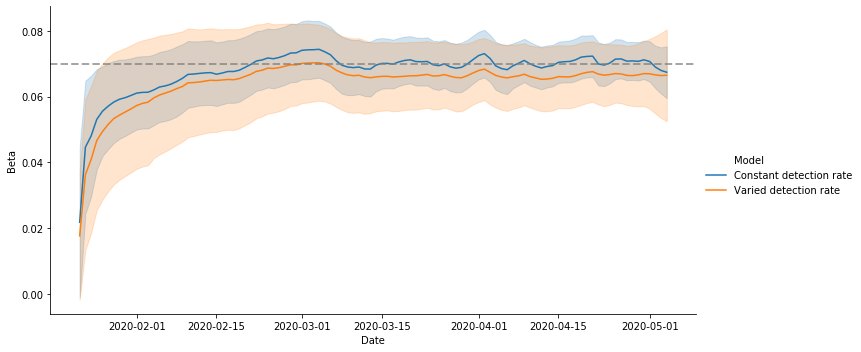

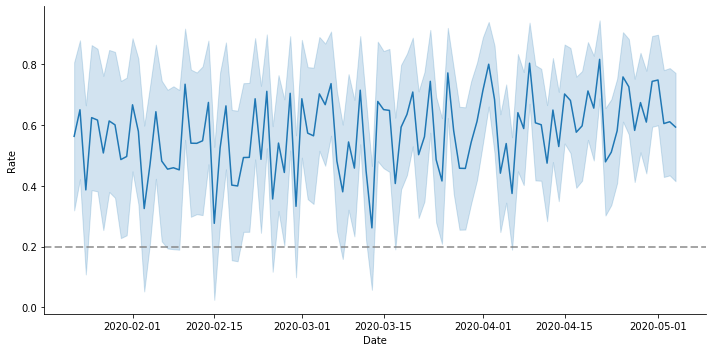

In [11]:
beta_const_q = extract_var(var_name='b', data=infered_const_q)
beta = extract_var(var_name='b', data=infered_every)
q = extract_var(var_name='q', data=infered_every)
draw({'Constant detection rate':beta_const_q, 'Varied detection rate':beta}, name='const_beta', line=0.07, 
     label_name='Model', value_name='Beta')
draw({'Estimated':q}, line=0.2, name='const_q', label_name=None, value_name='Rate')

In [12]:
#### Step-like detection rate ####
from scipy.stats import poisson
def simulate(b, q1, q2, init_inf, a, d, P, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q1)]
    D_obs = [0]
    R_obs = [0]
    q=[]
    for t in index:
        if t < pd.to_datetime('2020-04-01'):
            q.append(q1)
        else:
            q.append(q2)
        NI = poisson.rvs(b*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        I = I + NI - NR - ND
        C = C+NI
        C_obs.append(int(C_obs[-1]+poisson.rvs(q[-1]*NI)))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
    return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 
            'T':len(C_obs), 'T0':0, 'P':P, 'b_beta_0':0.1, 'q0':q1}, np.array(q)

data, q_true = simulate(0.07, 1, 0.5, 100, 0.04, 0.001, 1200_0000, index)

infered_const_q = fit_and_infer(sm=sm_const_q, data=data)
infered_every = fit_and_infer(sm=sm_every, data=data)


Inference for Stan model: anon_model_480ac5eb816fc9bbcdd0b556dd97733b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      85.79    0.25    9.1  69.45  79.38  85.52  91.54 104.02   1312    1.0
b_beta       3.9e-3 10.0e-5 1.2e-3 2.0e-3 3.0e-3 3.7e-3 4.6e-3 6.7e-3    151   1.02
b[1]           0.06  4.5e-4   0.01   0.03   0.05   0.06   0.07   0.08    991    1.0
b[2]           0.06  4.5e-4   0.01   0.03   0.05   0.06   0.07   0.08    811    1.0
b[3]           0.06  4.0e-4   0.01   0.04   0.05   0.06   0.07   0.08    905    1.0
b[4]           0.06  4.1e-4   0.01   0.04   0.05   0.06   0.07   0.08    772    1.0
b[5]           0.06  4.1e-4   0.01   0.04   0.05   0.06   0.07   0.08    756    1.0
b[6]           0.06  3.8e-4   0.01   0.04   0.05   0.06   0.07   0.08    832    1.0
b[7]           0.06  3.7e-4   0.01   0.04   0.06   0.06

Inference for Stan model: anon_model_b305bf3606a6c594794b11744bb1397a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     121.43    5.88  36.18  78.54  96.51 111.49 137.57 213.21     38   1.12
b_beta       2.8e-3  1.9e-4 1.1e-3 1.2e-3 2.0e-3 2.6e-3 3.5e-3 5.5e-3     34   1.09
b[1]           0.07  2.0e-3   0.02   0.04   0.06   0.07   0.08    0.1     72   1.08
b[2]           0.07  2.0e-3   0.02   0.04   0.06   0.07   0.08    0.1     65   1.09
b[3]           0.07  2.0e-3   0.02   0.04   0.06   0.07   0.08    0.1     62   1.09
b[4]           0.07  1.9e-3   0.01   0.04   0.06   0.07   0.08    0.1     59    1.1
b[5]           0.07  1.9e-3   0.01   0.04   0.06   0.08   0.08    0.1     59    1.1
b[6]           0.07  1.8e-3   0.01   0.05   0.07   0.08   0.08    0.1     61   1.09
b[7]           0.08  1.7e-3   0.01   0.05   0.07   0.08

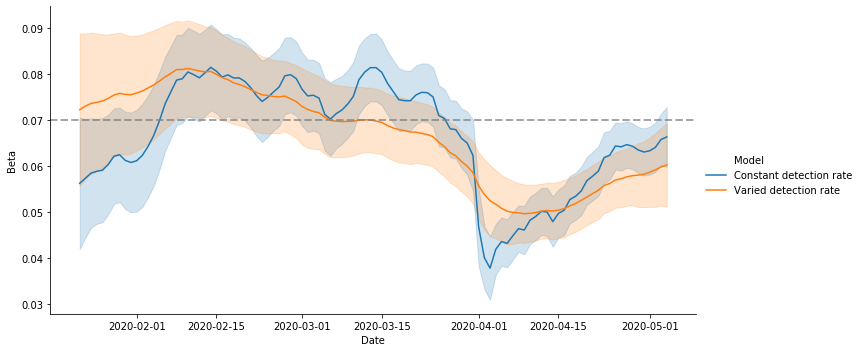

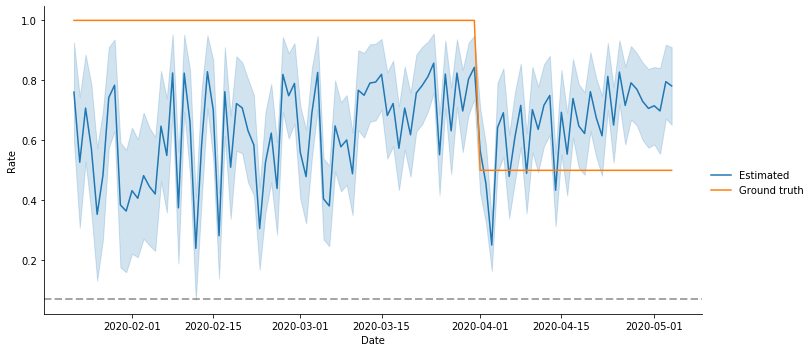

In [13]:
beta_const_q = extract_var(var_name='b', data=infered_const_q)
beta = extract_var(var_name='b', data=infered_every)
q = extract_var(var_name='q', data=infered_every)
                     
draw({'Constant detection rate':beta_const_q, 'Varied detection rate':beta}, name='step_beta', 
     label_name='Model', value_name='Beta', line=0.07)

q_true = pd.DataFrame(q_true, index)
draw({'Estimated':q, 'Ground truth':q_true}, name='step_q', line=0.07, value_name='Rate', label_name='')

In [14]:
#### Changing beta ####
from scipy.stats import poisson
def simulate(b0, b1, q0, init_inf, a, d, P, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q0)]
    q = [q0]
    D_obs = [0]
    R_obs = [0]
    b = [b0]
    for t in index:
        q.append(q0 + 0.05*np.random.randn(1)[0])
        NI = poisson.rvs(b[-1]*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        C = C+NI
        I = I + NI - NR - ND
        b.append(b[-1] - b1)
        C_obs.append(int(C_obs[-1]+poisson.rvs(q[-1]*NI)))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
 
    return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 
            'T':len(C_obs), 'T0':0, 'P':P, 'b_beta_0':1, 'q0':q0}, np.array(q), np.array(b)
data, q_true, b_true = simulate(0.16, 0.001, 0.5, 100, 0.04, 0.001, 1200_0000, index)

infered_const_q = fit_and_infer(sm=sm_const_q, data=data)
infered_every = fit_and_infer(sm=sm_every, data=data)


Inference for Stan model: anon_model_480ac5eb816fc9bbcdd0b556dd97733b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     111.81    0.31  14.65  85.42 101.53 110.82 121.23 142.89   2176    1.0
b_beta       7.9e-3  3.5e-5 1.2e-3 5.7e-3 7.1e-3 7.8e-3 8.6e-3   0.01   1223    1.0
b[1]           0.11  1.4e-3   0.04   0.02   0.09   0.12   0.14   0.18    810    1.0
b[2]           0.13  6.0e-4   0.03   0.08   0.12   0.13   0.15   0.18   1813    1.0
b[3]           0.14  4.5e-4   0.02    0.1   0.13   0.14   0.15   0.18   2137    1.0
b[4]           0.14  4.3e-4   0.02    0.1   0.13   0.14   0.15   0.18   2042    1.0
b[5]           0.14  4.1e-4   0.02   0.11   0.13   0.14   0.15   0.18   1956    1.0
b[6]           0.14  3.9e-4   0.02   0.11   0.13   0.14   0.16   0.18   1844    1.0
b[7]           0.15  3.8e-4   0.02   0.12   0.13   0.14

Inference for Stan model: anon_model_b305bf3606a6c594794b11744bb1397a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     122.05    2.34  50.89  60.08  86.57 110.51  143.8 253.45    472   1.01
b_beta       3.3e-3  8.3e-5 1.1e-3 1.7e-3 2.5e-3 3.2e-3 3.9e-3 5.9e-3    177   1.02
b[1]           0.11  1.2e-3   0.03   0.05    0.1   0.12   0.13   0.16    560   1.01
b[2]           0.12  1.0e-3   0.02   0.06    0.1   0.12   0.13   0.16    596    1.0
b[3]           0.12  9.9e-4   0.02   0.07    0.1   0.12   0.13   0.16    589    1.0
b[4]           0.12  9.6e-4   0.02   0.07   0.11   0.12   0.13   0.16    594    1.0
b[5]           0.12  9.1e-4   0.02   0.07   0.11   0.12   0.14   0.16    617    1.0
b[6]           0.12  8.8e-4   0.02   0.07   0.11   0.12   0.14   0.16    625    1.0
b[7]           0.12  8.5e-4   0.02   0.08   0.11   0.12

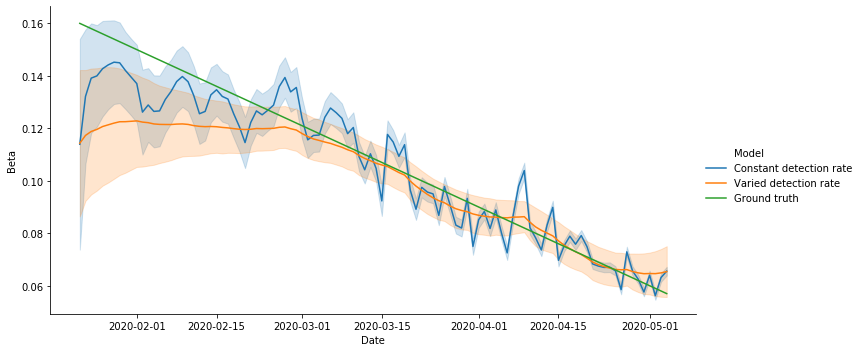

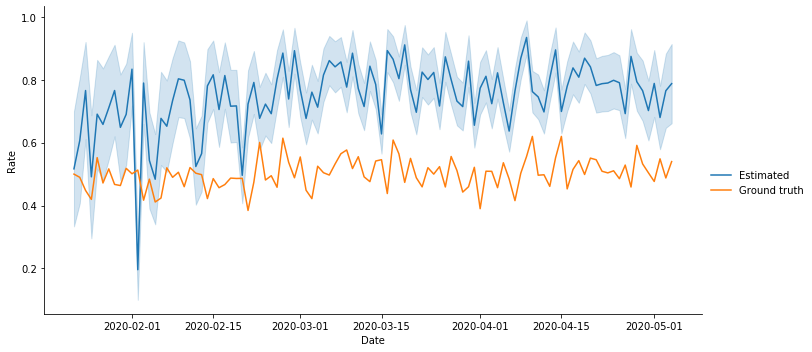

In [15]:
beta_const_q = extract_var(var_name='b', data=infered_const_q)
beta = extract_var('b', infered_every)
q = extract_var('q', infered_every)
b = extract_var('b', infered_every)
                  
b_true = pd.DataFrame(b_true[:-1], index)
draw({'Constant detection rate':beta_const_q, 'Varied detection rate':beta, 'Ground truth':b_true}, 
     name='trend_beta', label_name='Model', value_name='Beta')

q_true = pd.DataFrame(q_true[:-1], index)
draw({'Estimated':q, 'Ground truth':q_true}, name='trend_q', value_name='Rate', label_name='')

In [16]:
#### Satulate ####
from scipy.stats import poisson
def simulate(b, q, init_inf, a, d, P, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q)]
    R_obs = [0]
    D_obs = [0]
    for t in index:
        NI = poisson.rvs(b*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        I = I + NI - NR - ND
        C = C + NI
        R = R + NR
        D = ND
        C_obs.append(int(C_obs[-1]+poisson.rvs(q*NI)))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
    return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 'T':len(C_obs), 'T0':0, 'P':P, 'b_beta_0':0.1, 'q0':q}

data = simulate(0.30, 0.2, 100, 0.04, 0.001, 12000_0000, index)

infered_const_q = fit_and_infer(sm=sm_const_q, data=data)
infered_every = fit_and_infer(sm=sm_every, data=data)

Inference for Stan model: anon_model_480ac5eb816fc9bbcdd0b556dd97733b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf        2.0    1.64   2.31   0.34   0.49   0.85   3.64    6.1      2  60.76
b_beta         1.44    0.76   1.09   0.26   0.56   1.17   1.96   3.52      2  11.03
b[1]            3.9    1.77    2.5   0.21    1.8   3.97   5.82   7.31      2  69.74
b[2]            3.2    1.26   1.78    0.2   1.79   3.84    4.5   5.03      2  44.33
b[3]           2.25    1.55   2.19   0.31   0.45   1.41   4.19    5.9      2 124.38
b[4]           2.08    0.36   0.51   1.27   1.64   2.18   2.45   2.79      2  18.36
b[5]           4.44    1.56   2.21   0.81   2.52   5.07   6.24   6.81      2  38.09
b[6]           2.85    2.04   2.89   0.19   0.33   1.89   5.51   7.48      2 104.63
b[7]           2.92    1.98    2.8   0.14   0.23    2.4

Inference for Stan model: anon_model_b305bf3606a6c594794b11744bb1397a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      29.43    0.35   7.09  18.85  24.37  28.48  33.32  46.38    409   1.01
b_beta       3.8e-3  3.3e-4 1.4e-3 1.6e-3 2.8e-3 3.6e-3 4.7e-3 7.2e-3     18   1.26
b[1]           0.29  1.1e-3   0.02   0.24   0.27   0.29    0.3   0.33    466   1.01
b[2]           0.29  1.1e-3   0.02   0.24   0.27   0.29    0.3   0.33    410   1.01
b[3]           0.29  1.1e-3   0.02   0.24   0.28   0.29    0.3   0.33    390   1.01
b[4]           0.29  1.1e-3   0.02   0.25   0.28   0.29    0.3   0.33    340   1.02
b[5]           0.29  1.2e-3   0.02   0.25   0.28   0.29    0.3   0.33    259   1.02
b[6]           0.29  1.3e-3   0.02   0.25   0.28   0.29    0.3   0.33    201   1.03
b[7]           0.29  1.4e-3   0.02   0.25   0.28   0.29

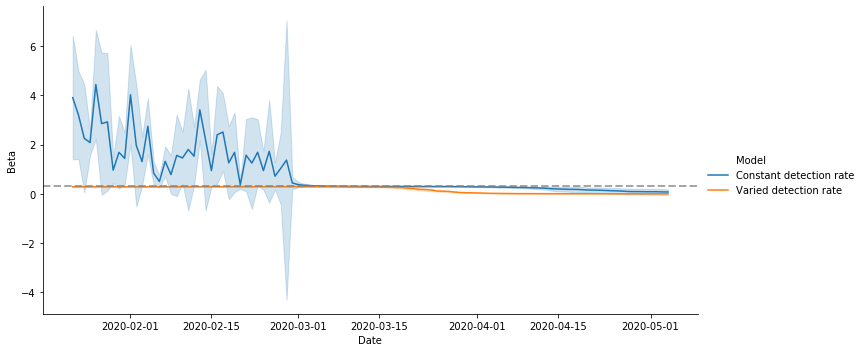

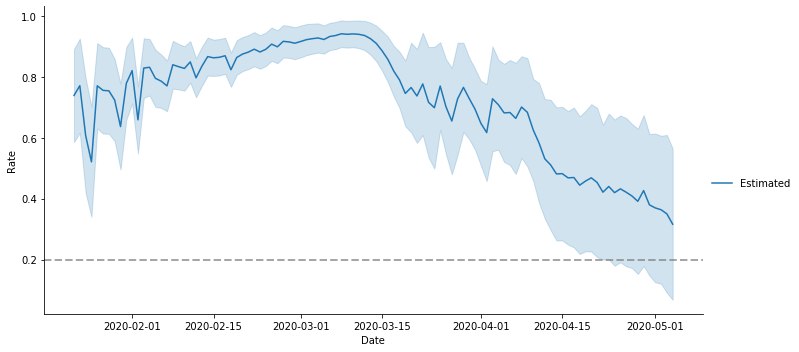

In [17]:
beta_const_q = extract_var('b', infered_const_q)
beta = extract_var('b', infered_every)
q = extract_var('q', infered_every)
draw({'Constant detection rate':beta_const_q, 'Varied detection rate':beta}, name='const_beta', line=0.30, 
     label_name='Model', value_name='Beta')
draw({'Estimated':q}, line=0.2, name='const_q', value_name='Rate', label_name='')

In [18]:
## Analysis ##
iteration = 10000

In [19]:
### Japanese case ###
P = 126_500_000
infer_const = fit_and_infer(sm=sm_const, country='Japan', population=P, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country='Japan', population=P, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country='Japan', population=P, iteration=iteration)
loo = az.loo(infer_const, pointwise=True)
print(loo)
loo = az.loo(infer_const_q, pointwise=True)
print(loo)
loo = az.loo(infer, pointwise=True)
print(loo)
print(az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer}))

Inference for Stan model: anon_model_e016c2803a6aaef99e20fd9e9c81e7a9.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       14.2    0.02   3.53   8.01   11.7  13.97  16.44  21.85  20972    1.0
b              0.09  5.9e-6 8.0e-4   0.09   0.09   0.09   0.09   0.09  18408    1.0
q               1.0  2.7e-6 4.6e-4    1.0    1.0    1.0    1.0    1.0  30354    1.0
NI[1]          1.37  6.2e-3   0.85   0.09    0.7   1.27   1.91   3.24  18846    1.0
NI[2]          1.45  6.3e-3   0.87   0.11   0.78   1.36    2.0   3.38  19059    1.0
NI[3]          1.54  6.5e-3   0.92   0.12   0.83   1.43   2.11   3.58  19811    1.0
NI[4]          2.56  6.4e-3   0.93   0.92   1.89   2.51   3.15   4.53  21255    1.0
NI[5]          1.74  7.3e-3    1.0   0.15   0.98   1.66   2.39   3.93  18663    1.0
NI[6]          3.19  6.8e-3   1.02   1.37   2.45   3.

Inference for Stan model: anon_model_480ac5eb816fc9bbcdd0b556dd97733b.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       1.63  6.9e-3   0.85   0.46   1.02   1.47   2.06    3.7  15295    1.0
b_beta         0.06  6.0e-5 7.3e-3   0.05   0.06   0.06   0.07   0.08  14797    1.0
b[1]           0.09  6.7e-4   0.08 3.9e-3   0.03   0.07   0.12   0.29  12967    1.0
b[2]           0.14  8.7e-4   0.09   0.01   0.07   0.12   0.19   0.36  11161    1.0
b[3]           0.19  1.0e-3    0.1   0.03   0.11   0.17   0.25   0.41   9944    1.0
b[4]           0.23  1.0e-3    0.1   0.07   0.16   0.22   0.29   0.45   9133    1.0
b[5]           0.25  1.1e-3    0.1   0.07   0.18   0.24   0.31   0.46   8522    1.0
b[6]           0.27  9.7e-4    0.1   0.11    0.2   0.26   0.33   0.48   9607    1.0
b[7]           0.26  9.6e-4    0.1   0.09    0.2   0.

Inference for Stan model: anon_model_b305bf3606a6c594794b11744bb1397a.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       5.66    0.09    5.2   1.15   2.63   4.14   6.76  19.78   3705    1.0
b_beta         0.01  1.1e-4 3.9e-3 8.1e-3   0.01   0.01   0.02   0.02   1352    1.0
b[1]           0.06  1.0e-3   0.06 1.5e-3   0.01   0.04   0.09   0.22   3832    1.0
b[2]            0.1  1.1e-3   0.07 7.2e-3   0.04   0.08   0.14   0.25   3654    1.0
b[3]           0.12  9.9e-4   0.06   0.02   0.07   0.12   0.16   0.26   4306    1.0
b[4]           0.14  8.7e-4   0.06   0.04    0.1   0.14   0.18   0.27   4623    1.0
b[5]           0.15  8.3e-4   0.06   0.05   0.11   0.15   0.19   0.27   4485    1.0
b[6]           0.16  7.5e-4   0.05   0.07   0.12   0.16   0.19   0.27   4762    1.0
b[7]           0.16  7.2e-4   0.05   0.07   0.13   0.

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo  4349.27   725.52
p_loo   1104.02        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       29   27.6%
 (0.5, 0.7]   (ok)         28   26.7%
   (0.7, 1]   (bad)         6    5.7%
   (1, Inf)   (very bad)   42   40.0%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo   758.90    28.96
p_loo     92.00        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        8    7.6%
 (0.5, 0.7]   (ok)         15   14.3%
   (0.7, 1]   (bad)        66   62.9%
   (1, Inf)   (very bad)   16   15.2%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densiti

Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo   747.79    28.84
p_loo     88.86        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        5    4.8%
 (0.5, 0.7]   (ok)         14   13.3%
   (0.7, 1]   (bad)        76   72.4%
   (1, Inf)   (very bad)   10    9.5%

         rank     waic   p_waic   d_waic     weight       se      dse warning  \
Varied_q    0  678.091   54.007        0   0.954644    984.6        0    True   
Const_q     1  686.968  56.0322  8.87659  0.0453563  27.4406  3.66299    True   
Const       2  5131.83  1495.31  4453.74          0  28.2581  974.718    True   

         waic_scale  
Varied_q   deviance  
Const_q    deviance  
Const      deviance  


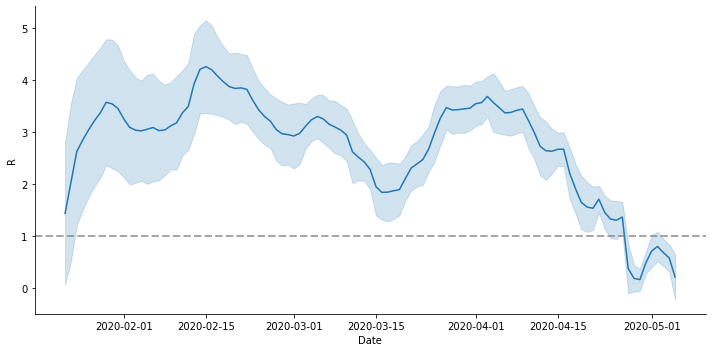

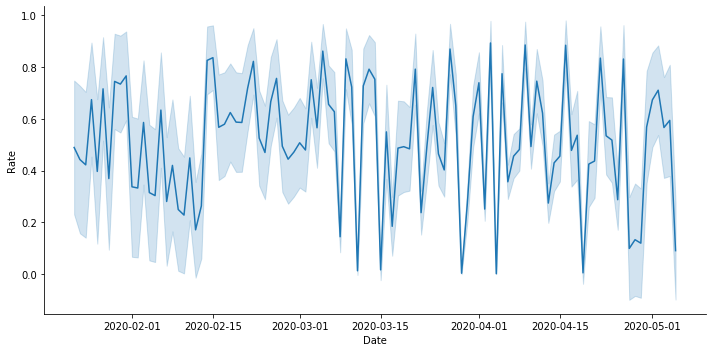

In [20]:
beta = extract_var(var_name='b', data=infer)
q = extract_var(var_name='q', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
d = extract_var(var_name='d', data=infer)
R_J = pd.DataFrame(np.array([(beta[i].values / (d.iloc[i].values + 0.04)) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_J}, line=1, name='R_Japan', value_name='R')
draw({'Detection rate':q}, name='q_Japan', value_name='Rate')

In [21]:
### China ###
P = 1_393_000_000
country='China'
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, iteration=iteration)
loo = az.loo(infer_const, pointwise=True)
print(loo)
loo = az.loo(infer_const_q, pointwise=True)
print(loo)
loo = az.loo(infer, pointwise=True)
print(loo)
az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer})

Inference for Stan model: anon_model_e016c2803a6aaef99e20fd9e9c81e7a9.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     6494.5    0.49  83.96 6331.1 6437.7 6494.3 6551.0 6661.9  29762    1.0
b              0.06  1.5e-6 2.8e-4   0.06   0.06   0.06   0.06   0.06  31520    1.0
q               1.0  2.3e-7 3.9e-5    1.0    1.0    1.0    1.0    1.0  29528    1.0
NI[1]        451.64     0.1  17.98  416.9 439.54 451.49 463.75 487.34  34993    1.0
NI[2]        575.95    0.09  16.87 543.32 564.45 575.86 587.36  609.2  34870    1.0
NI[3]        689.77    0.09  17.04 656.45 678.25 689.68  701.3 723.68  34651    1.0
NI[4]        783.27    0.09  16.69 750.33 772.08 783.32 794.39 815.97  36360    1.0
NI[5]        856.86    0.09  17.47 822.83 845.03 856.88  868.8 890.78  36479    1.0
NI[6]        1346.2     0.1  17.05 1312.7 1334.6 1346

Inference for Stan model: anon_model_480ac5eb816fc9bbcdd0b556dd97733b.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     556.18    0.17  22.89 512.26 540.56 555.95 571.49 601.63  18453    1.0
b_beta       7.1e-3  7.9e-6 1.2e-3 5.0e-3 6.2e-3 7.0e-3 7.8e-3 9.9e-3  24821    1.0
b[1]           0.17  1.6e-4   0.03   0.12   0.15   0.17   0.19   0.23  28967    1.0
b[2]           0.48  1.8e-4   0.02   0.44   0.46   0.48   0.49   0.52  13341    1.0
b[3]           0.48  1.7e-4   0.02   0.45   0.47   0.48   0.49   0.52  12219    1.0
b[4]           0.48  1.6e-4   0.02   0.44   0.46   0.48   0.49   0.51  12213    1.0
b[5]           0.46  1.7e-4   0.02   0.42   0.45   0.46   0.48    0.5  13768    1.0
b[6]           0.98  2.1e-4   0.03   0.92   0.96   0.98    1.0   1.05  24892    1.0
b[7]           0.11  4.1e-5 6.9e-3    0.1   0.11   0.

Inference for Stan model: anon_model_b305bf3606a6c594794b11744bb1397a.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     9772.5    28.0 1379.4 7529.5 8825.7 9618.6  1.1e4  1.3e4   2428    1.0
b_beta       1.2e-3  4.8e-6 2.7e-4 7.2e-4 9.7e-4 1.1e-3 1.3e-3 1.8e-3   3322    1.0
b[1]           0.16  1.8e-410.0e-3   0.14   0.16   0.16   0.17   0.18   3130    1.0
b[2]           0.16  1.8e-4 9.9e-3   0.15   0.16   0.16   0.17   0.18   3038    1.0
b[3]           0.16  1.8e-4 9.8e-3   0.15   0.16   0.16   0.17   0.18   2940    1.0
b[4]           0.16  1.8e-4 9.7e-3   0.15   0.16   0.16   0.17   0.18   2838    1.0
b[5]           0.16  1.8e-4 9.6e-3   0.15   0.16   0.16   0.17   0.18   2745    1.0
b[6]           0.16  1.8e-4 9.5e-3   0.15   0.16   0.16   0.17   0.18   2671    1.0
b[7]           0.16  1.8e-4 9.3e-3   0.15   0.16   0.

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo 40272.00  18014.32
p_loo   3858.89        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          1    1.0%
   (0.7, 1]   (bad)         7    6.7%
   (1, Inf)   (very bad)   97   92.4%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo   971.55    24.64
p_loo     97.96        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          4    3.8%
   (0.7, 1]   (bad)        85   81.0%
   (1, Inf)   (very bad)   16   15.2%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo   951.70    22.65
p_loo     90.32        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        1    1.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)        97   92.4%
   (1, Inf)   (very bad)    7    6.7%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Varied_q,0,873.492,51.2161,0,0.996445,28117.9,0,True,deviance
Const_q,1,888.808,56.5944,15.3159,0.00355471,23.6808,5.34551,True,deviance
Const,2,56094.6,11770.2,55221.1,0,22.6487,26841,True,deviance


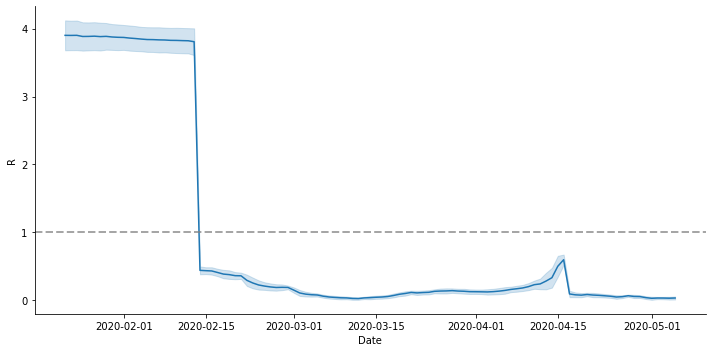

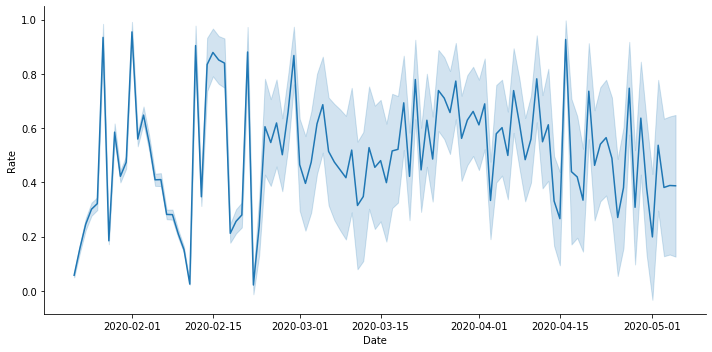

In [22]:
beta = extract_var(var_name='b', data=infer)
q = extract_var(var_name='q', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
d = extract_var(var_name='d', data=infer)
R_C = pd.DataFrame(np.array([(beta[i].values / (d.iloc[i].values + 0.04)) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_C}, line=1, name='R_China', value_name='R')
draw({'Detection rate':q}, name='q_China', value_name='Rate')

In [23]:
### US ###
P = 327_200_000
country='US'
start=pd.to_datetime('2020-02-01')
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, start=start, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, start=start, iteration=iteration)
loo = az.loo(infer_const, pointwise=True)
print(loo)
loo = az.loo(infer_const_q, pointwise=True)
print(loo)
loo = az.loo(infer, pointwise=True)
print(loo)
az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer})

Inference for Stan model: anon_model_e016c2803a6aaef99e20fd9e9c81e7a9.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     205.06    0.08  15.23 176.36 194.67 204.67 214.95 236.03  34651    1.0
b              0.09  6.3e-7 9.1e-5   0.09   0.09   0.09   0.09   0.09  20558    1.0
q               1.0  9.3e-8 1.6e-5    1.0    1.0    1.0    1.0    1.0  28392    1.0
NI[1]         19.19    0.03   4.18  11.05  16.37  19.16  21.97  27.52  27078    1.0
NI[2]         21.78    0.03   4.19  13.59  18.96  21.78  24.59  30.11  27382    1.0
NI[3]         22.86    0.03   4.38  14.27  19.88  22.84  25.83  31.42  30191    1.0
NI[4]         27.17    0.02   4.33  18.81  24.22  27.13  30.08  35.74  31007    1.0
NI[5]         27.24    0.03   4.57  18.32  24.18  27.24  30.26  36.27  30394    1.0
NI[6]         29.71    0.03   4.82  20.34   26.5  29.

Inference for Stan model: anon_model_480ac5eb816fc9bbcdd0b556dd97733b.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       1.43    0.09   0.74   0.37   0.87   1.29   1.94   3.08     61   1.08
b_beta         0.11    0.09   0.14   0.02   0.03   0.03   0.16   0.49      2   3.35
b[1]           0.13    0.09   0.14 3.1e-3   0.03   0.06   0.26   0.48      2   2.65
b[2]           0.19    0.11   0.16   0.02   0.06   0.11   0.36    0.5      2   3.31
b[3]            1.0    1.04   1.82   0.02   0.08   0.13   0.97   6.12      3   5.06
b[4]           0.37    0.29   0.43   0.04    0.1   0.15   0.71   1.43      2   5.61
b[5]            0.6    0.57   0.86   0.04    0.1   0.15   0.86    2.6      2   9.36
b[6]           0.13  2.2e-3   0.05   0.03    0.1   0.12   0.17   0.25    566   1.02
b[7]           0.57    0.54   0.81   0.03    0.1   0.

Inference for Stan model: anon_model_b305bf3606a6c594794b11744bb1397a.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       2.99    0.03   2.41   0.64   1.54   2.36   3.64   9.13   6843    1.0
b_beta         0.02  9.5e-5 3.8e-3   0.01   0.01   0.02   0.02   0.02   1618    1.0
b[1]           0.05  6.5e-4   0.05 2.0e-3   0.02   0.04   0.08   0.19   6043    1.0
b[2]           0.09  6.8e-4   0.05   0.01   0.05   0.08   0.11   0.21   5758    1.0
b[3]            0.1  6.8e-4   0.05   0.02   0.06   0.09   0.13   0.22   5472    1.0
b[4]           0.11  6.5e-4   0.05   0.04   0.08    0.1   0.14   0.22   5404    1.0
b[5]           0.11  6.6e-4   0.05   0.04   0.08   0.11   0.14   0.22   5080    1.0
b[6]           0.12  6.5e-4   0.05   0.04   0.08   0.11   0.14   0.22   5089    1.0
b[7]           0.12  6.4e-4   0.05   0.04   0.09   0.

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo 119871.76  12076.04
p_loo  11851.35        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        1    1.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         4    3.8%
   (1, Inf)   (very bad)  100   95.2%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:759: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 

Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo 18703812.63  2135945.96
p_loo  9351477.64        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       24   22.9%
 (0.5, 0.7]   (ok)          5    4.8%
   (0.7, 1]   (bad)         6    5.7%
   (1, Inf)   (very bad)   70   66.7%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo  1004.63    58.87
p_loo     88.67        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       14   13.3%
 (0.5, 0.7]   (ok)         13   12.4%
   (0.7, 1]   (bad)        73   69.5%
   (1, Inf)   (very bad)    5    4.8%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Varied_q,0,940.462,56.5891,0,1,1.42395e+10,0,True,deviance
Const,1,180727,42278.9,179786,0,55.5646,19892.2,True,deviance
Const_q,2,1.12658e+11,5.63291e+10,1.12658e+11,0,18655.6,1.45393e+10,True,deviance


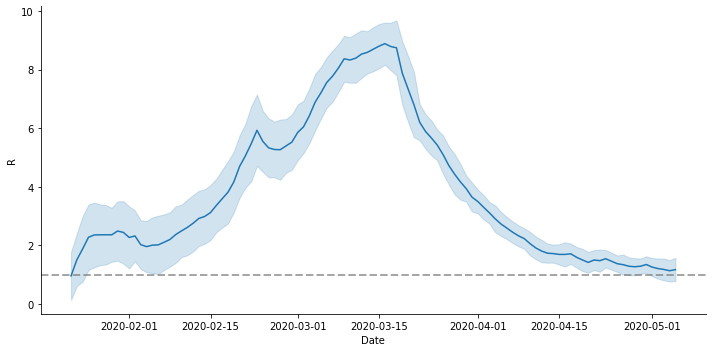

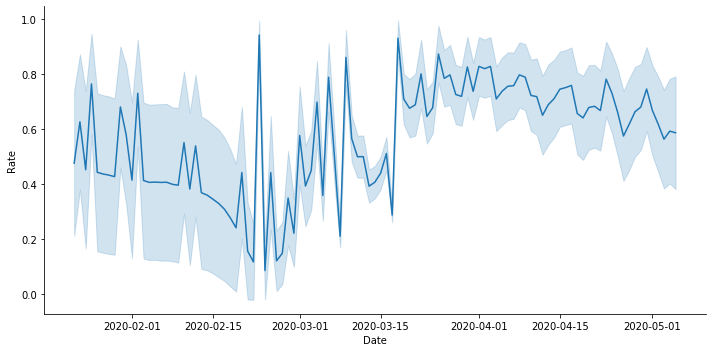

In [24]:
beta = extract_var(var_name='b', data=infer)
q = extract_var(var_name='q', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
d = extract_var(var_name='d', data=infer)
R_US = pd.DataFrame(np.array([(beta[i].values / (d.iloc[i].values + 0.04)) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_US}, line=1, name='R_US', value_name='R')
draw({'Detection rate':q}, name='q_US', value_name='Rate')

In [25]:
# ### Italy ###
# P = 60_360_000
# country='Italy'
# start=pd.to_datetime('2020-01-22')
# infer_const = fit_and_infer(sm=sm_const, country=country, population=P, start=start, iteration=iteration)
# infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration)
# infer = fit_and_infer(sm=sm_every, country=country, population=P, start=start, iteration=iteration)
# loo = az.loo(infer_const, pointwise=True)
# print(loo)
# loo = az.loo(infer_const_q, pointwise=True)
# print(loo)
# loo = az.loo(infer, pointwise=True)
# print(loo)
# az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer})

In [26]:
# beta = extract_var(var_name='b', data=infer)
# q = extract_var(var_name='q', data=infer)
# C = extract_var(var_name='C', data=infer)
# C = C[:-1]
# d = extract_var(var_name='d', data=infer)
# R_I = pd.DataFrame(np.array([(beta[i].values / (d.iloc[i].values + 0.04)) * (1 - C[i]/P) for i in range(len(beta))]).T,
#                  index=beta.index)

# draw({'R':R_I}, line=1, name='R_Italy', value_name='R')
# draw({'Detection rate':q}, name='q_Italy', value_name='Rate')

In [27]:
### Korea ###
P = 51_640_000
country='Korea, South'
start=pd.to_datetime('2020-01-22')
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, start=start, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, start=start, iteration=iteration)
loo = az.loo(infer_const, pointwise=True)
print(loo)
loo = az.loo(infer_const_q, pointwise=True)
print(loo)
loo = az.loo(infer, pointwise=True)
print(loo)
az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer})

Inference for Stan model: anon_model_e016c2803a6aaef99e20fd9e9c81e7a9.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     139.65    0.07  13.37  114.5  130.5 139.31  148.4 167.19  36846    1.0
b              0.06  3.9e-6 7.2e-4   0.06   0.06   0.06   0.06   0.07  34072    1.0
q               1.0  2.1e-6 3.6e-4    1.0    1.0    1.0    1.0    1.0  30732    1.0
NI[1]          9.19    0.02    2.9   3.45   7.23   9.14  11.15  14.89  20936    1.0
NI[2]         10.61    0.02   2.83   5.16   8.67   10.6  12.53  16.17  31033    1.0
NI[3]         10.38    0.02   3.02   4.44   8.35  10.37  12.42  16.25  23871    1.0
NI[4]         11.87    0.02    2.9   6.31   9.89  11.81  13.83  17.62  31751    1.0
NI[5]         12.54    0.02   3.03   6.66  10.47   12.5  14.57  18.53  33614    1.0
NI[6]         12.52    0.02   3.19   6.28  10.34  12.

Inference for Stan model: anon_model_480ac5eb816fc9bbcdd0b556dd97733b.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       2.45    0.02   1.36   0.63    1.5   2.17   3.08   5.89   3044    1.0
b_beta       9.1e-3  3.3e-5 1.7e-3 6.2e-3 7.9e-3 8.9e-3   0.01   0.01   2540    1.0
b[1]           0.06  1.5e-3   0.06 1.4e-3   0.01   0.04    0.1   0.19   1493    1.0
b[2]           0.09  1.3e-3   0.05   0.01   0.05   0.09   0.13    0.2   1716    1.0
b[3]            0.1  1.2e-3   0.05   0.02   0.07    0.1   0.13    0.2   1668    1.0
b[4]           0.11  1.0e-3   0.04   0.04   0.08   0.11   0.14    0.2   1722    1.0
b[5]           0.12  9.8e-4   0.04   0.05   0.09   0.12   0.14    0.2   1744    1.0
b[6]           0.12  9.2e-4   0.04   0.05    0.1   0.12   0.15    0.2   1782    1.0
b[7]           0.13  8.9e-4   0.04   0.06    0.1   0.

Inference for Stan model: anon_model_b305bf3606a6c594794b11744bb1397a.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     453.48  344.32 625.25   0.42   1.02   2.18 1039.2 1768.4      3   2.87
b_beta       2.7e-3  3.2e-4 1.3e-3 1.1e-3 1.8e-3 2.4e-3 3.3e-3 6.2e-3     17   1.35
b[1]            0.1    0.04   0.12 1.8e-4 1.5e-3 4.2e-3   0.25    0.3     10   1.75
b[2]           0.14    0.07   0.13 6.2e-4 3.0e-3   0.21   0.27   0.31      4   2.28
b[3]           0.15    0.07   0.13 5.3e-4 3.2e-3   0.22   0.27    0.3      4   2.32
b[4]           0.16    0.08   0.13 8.9e-4 3.8e-3   0.24   0.27   0.31      3    3.4
b[5]           0.16    0.08   0.13 9.8e-4 4.1e-3   0.24   0.27   0.31      3   3.48
b[6]           0.16    0.08   0.13 7.0e-4 4.1e-3   0.24   0.27   0.31      3   3.55
b[7]           0.16    0.08   0.13 8.1e-4 4.7e-3   0.

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo  7057.37  1234.14
p_loo   1390.43        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        2    1.9%
 (0.5, 0.7]   (ok)          6    5.7%
   (0.7, 1]   (bad)        28   26.7%
   (1, Inf)   (very bad)   69   65.7%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo   767.54    39.84
p_loo     92.30        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       19   18.1%
 (0.5, 0.7]   (ok)          9    8.6%
   (0.7, 1]   (bad)        68   64.8%
   (1, Inf)   (very bad)    9    8.6%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is g

Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo   729.34    27.84
p_loo     82.70        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        2    1.9%
 (0.5, 0.7]   (ok)         10    9.5%
   (0.7, 1]   (bad)        88   83.8%
   (1, Inf)   (very bad)    5    4.8%



,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Varied_q,0,663.696,49.8772,0,0.998547,1506.09,0,True,deviance
Const_q,1,712.442,64.7492,48.7451,0.00145344,37.6282,24.3731,True,deviance
Const,2,7708.81,1716.15,7045.11,0,25.9037,1490.38,True,deviance


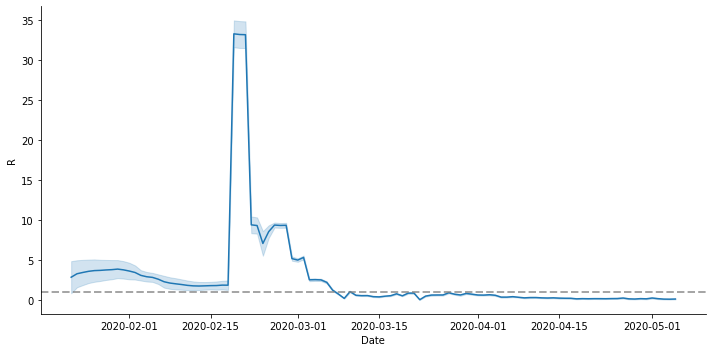

In [28]:
beta = extract_var(var_name='b', data=infer_const_q)
C = extract_var(var_name='C', data=infer_const_q)
C = C[:-1]
d = extract_var(var_name='d', data=infer_const_q)
#print('{}, {}, {}'.format(beta.values.shape, d.values.shape, C.values.shape))
R_K = pd.DataFrame(np.array([(beta[i].values / (d.iloc[i].values + 0.04)) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_K}, line=1, name='R_Korea', value_name='R')

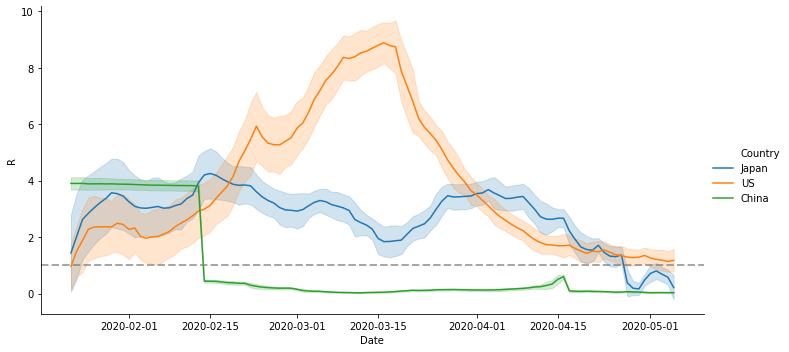

In [29]:
draw({'Japan':R_J, 'US':R_US, 'China':R_C}, line=1, name='R_multi', value_name='R', label_name='Country')